# 實作KNN 手寫 數字辨識

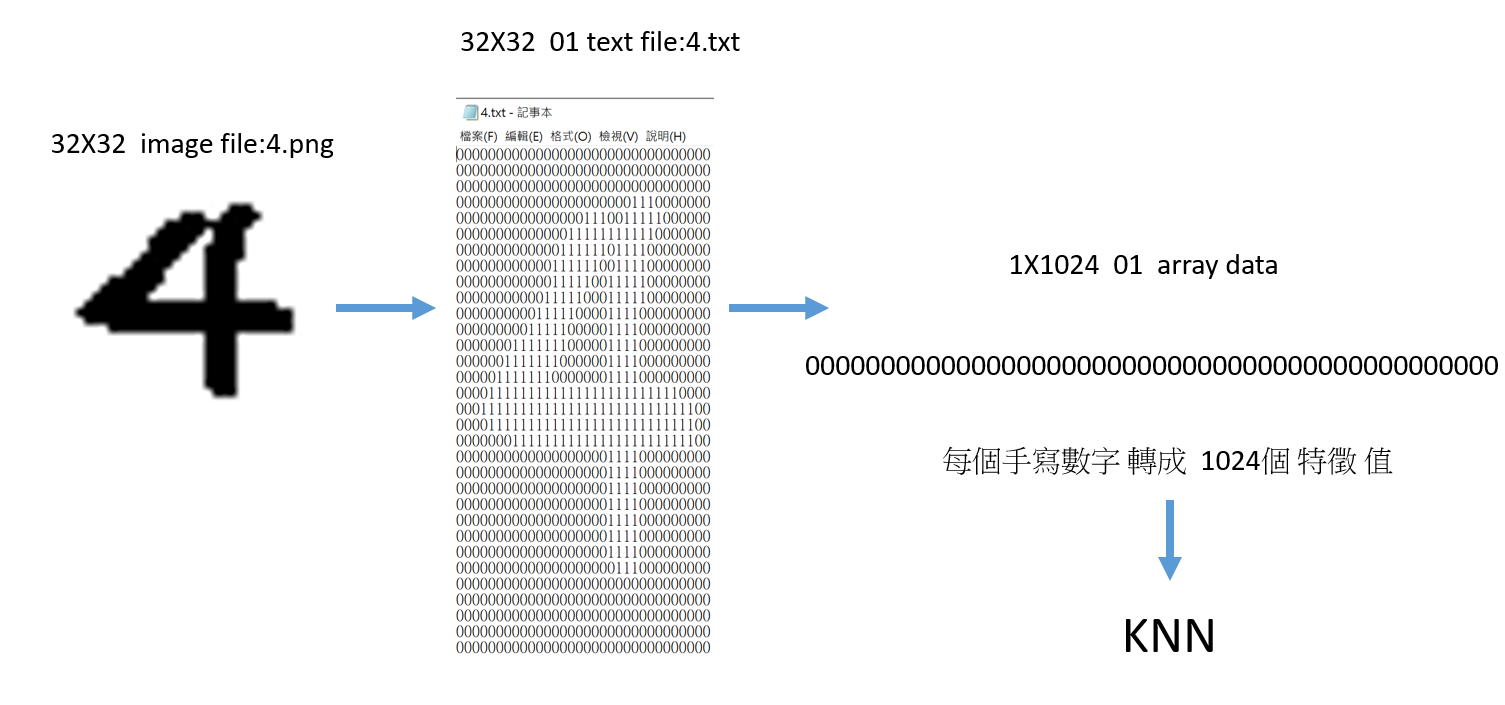

## Step1: 用小畫家 自己製作一個 32X32 的 準備用來辨識的手寫數字檔

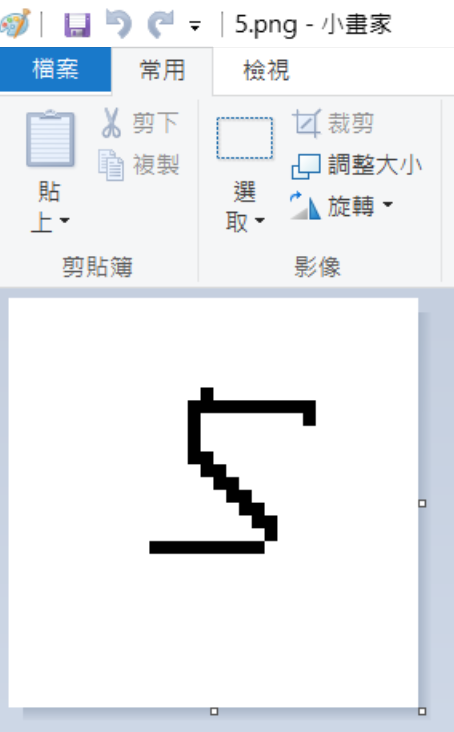

## Step2 將手寫檔讀入  並轉存為 0,1的文字檔(有寫到的地方為 1,沒有的為0)

In [1]:
#導入PIL模塊
from PIL import Image
#讀取圖片
im=Image.open("7_t.png") #欲辨識的影像
#打開要寫入的文本文檔
fh=open("7_t.txt","w") #將影像轉為 0 1文字矩陣檔
width=im.size[0]
height=im.size[1]
#讀取圖片中的每一個像素
for i in range(0,height):
    for j in range(0,width):
        cl=im.getpixel((j,i))
        clall=cl[0]+cl[1]+cl[2]
        #如果是黑色，黑色的RGB值均爲0
        if(clall==0):
            #在txt中寫入1
            fh.write("1")
        else:
            #在txt中寫入0
            fh.write("0")
    #讀取完之後進行換行
    fh.write("\n")
#關閉文本文件
fh.close()
fh=open("7_t.txt")
for i in range(0,32): 
    print(fh.readline())

FileNotFoundError: [Errno 2] No such file or directory: '7_t.png'

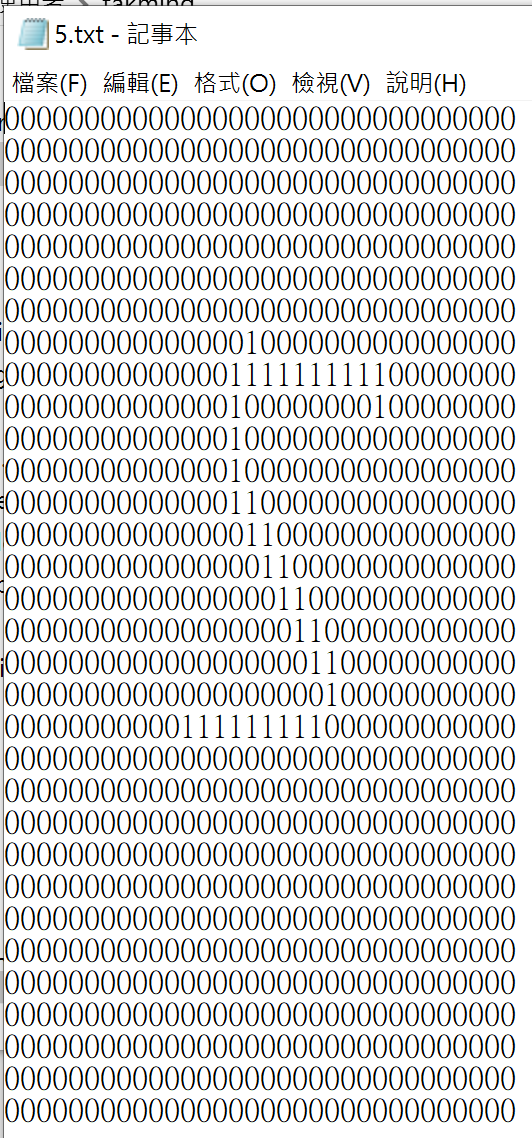

## Step3 準備測試數據及訓練數據：
### 下載 digits
#### 0_1.txt  ==>0 數字標籤   , 1 樣本序號
#### 输入格式：每个手写数字已经事先处理成32*32的二进制文本，存储为txt文件。0～9每个数字都有10个训练样本，5个测试样本。

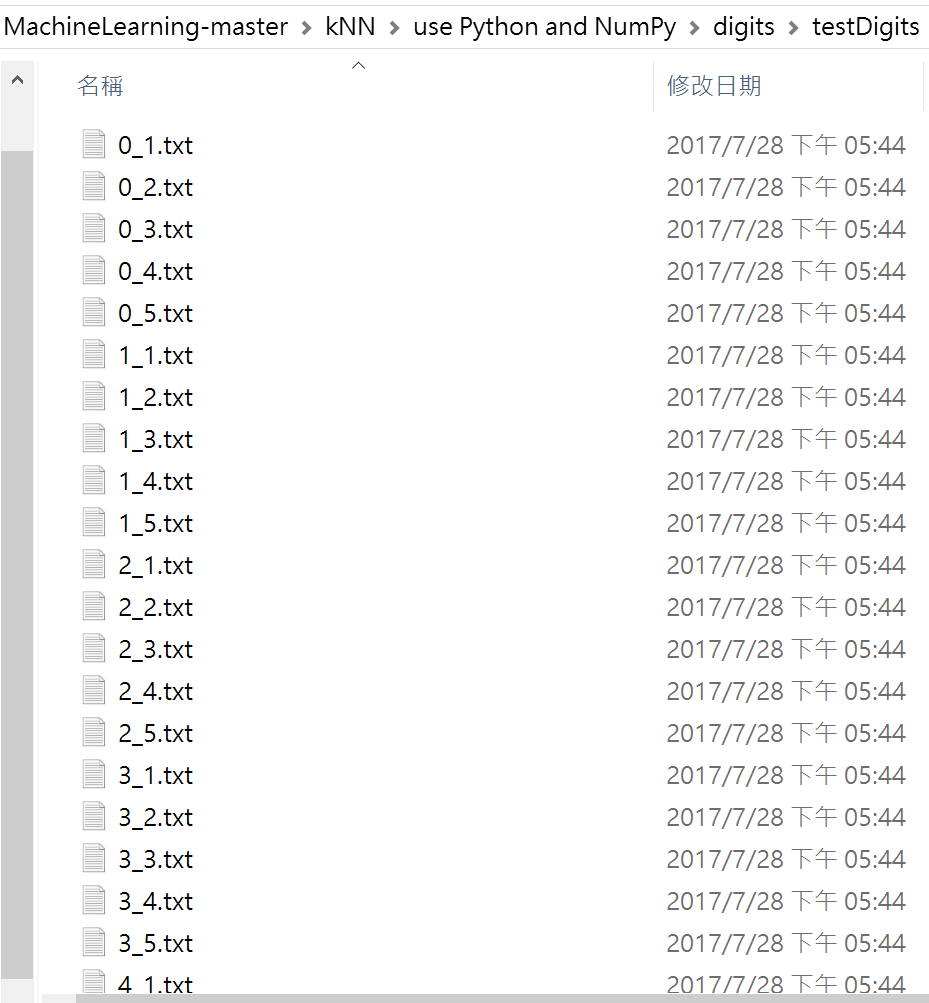

## Step4  熟悉幾個會用到的 Python 矩陣處理指令
### numpy函数
NumPy库总包含两种基本的数据类型：矩阵和数组，矩阵的使用类似Matlab，本实例用得多的是数组array。
### shape()
shape是numpy函数库中的方法，用于查看矩阵或者数组的维素<br>
shape(array) 若矩阵有m行n列，则返回(m,n)<br>
array.shape[0] 返回矩阵的行数m，参数为1的话返回列数n<br>

Ex:現有：a=array([1,5,6,4])<br>
.shape方法，獲取行列數，當shape[0]爲獲取列數(col)，shape[1]爲獲取行數(row)，如：<br>
e=a.shape[0]  #結果：4<br>

In [82]:
a=array([1,5,6,4])
print(a.shape[0])

4


## tile()
tile是numpy函数库中的方法，用法如下:<br>
tile(A,(m,n))  将数组A作为元素构造出m行n列的数组<br>
在原有數組基礎上，進行行或列的擴展，如：<br>

b=tile(a,2)       #行方向擴展爲2倍，變成了  1，5，6，4，1，5，6，4<br>
c=tile(a,(2,1))   #列方向擴展爲2倍，變成了  1，5，6，4<br>
                                     #    1，5，6，4<br>
d=tile(a,(2,2))   #行列方向均2行2列，變成了 1，5，6，4，1，5，6，4<br>
                                     #    1，5，6，4，1，5，6，4<br>

In [83]:
print(tile(a,2))

[1 5 6 4 1 5 6 4]


### sum()
sum()是numpy函数库中的方法<br>
array.sum(axis=1)按行累加，axis=0为按列累加 ,.sum()所有求和，如：<br>
 a.sum(axis=0) #結果：16<br>


In [84]:
print(a.sum(axis=0))

16


### argsort()
argsort()是numpy中的方法，得到矩阵中每个元素的排序序号<br>
A=array.argsort()  A[0]表示排序后 排在第一个的那个数在原来数组中的下标,<br>

In [85]:
print(a.argsort())

[0 3 1 2]


### dict.get(key,x)
python中字典的方法，get(key,x)从字典中获取key对应的value，字典中没有key的话返回0<br>
### sorted()
python中的方法<br>
### min()、max()
numpy中有min()、max()方法，用法如下<br>
array.min(0)  返回一个数组，数组中每个数都是它所在列的所有数的最小值<br>
array.min(1)  返回一个数组，数组中每个数都是它所在行的所有数的最小值<br>
### listdir('str')
python的operator中的方法<br>
  strlist=listdir('str')  读取目录str下的所有文件名，返回一个字符串列表<br>
### split()
python中的方法，切片函数<br>
 string.split('str')以字符str为分隔符切片，返回list<br>
### zeros
返回来一个给定形状和类型的用0填充的数组

## Step5 正式編寫代碼
编程实现，大概分为三个步骤：
（1）将每个图片（即txt文本，以下提到图片都指txt文本）转化为一个向量，即32X32的数组转化为1 X 1024的数组，这个1 X 1024的数组用机器学习的术语来说就是特征向量。

（2）训练样本中有10 X 10个图片，可以合并成一个100 X 1024的矩阵，每一行对应一个图片。（这是为了方便计算，很多机器学习算法在计算的时候采用矩阵运算，可以简化代码，有时还可以减少计算复杂度）。

（3）测试样本中有10 X 5个图片，我们要让程序自动判断每个图片所表示的数字。同样的，对于测试图片，将其转化为1 X 1024的向量，然后计算它与训练样本中各个图片的“距离”（这里两个向量的距离采用欧式距离），然后对距离排序，选出较小的前k个，因为这k个样本来自训练集，是已知其代表的数字的，所以被测试图片所代表的数字就可以确定为这k个中出现次数最多的那个数字。


In [4]:
from numpy import *
import operator
from os import listdir

In [5]:
#加載單個數據(.txt)，將數值矩陣轉換爲1行的數組並返回==>1 X 1024(32X32)
def dataoarray(fname):
    arr=[]
    fh=open(fname)
    for i in range(0,32):
        thisline=fh.readline()
        for j in range(0,32):
            arr.append(int(thisline[j]))
    return arr

#由於測試及訓練數據的名稱爲"數字類型_序號.txt"，
#因此需建立一個函數去文件名的前綴來獲取數字類型
def seplabel(fname):
    filestr=fname.split(".")[0]
    label=int(filestr.split("_")[0])
    return label

#建立訓練數據，讀取所有訓練數據
def traindata():
    labels=[]
    trainfile=listdir("digits/trainingDigits")  #得到一個文件夾下所有文件名
    num=len(trainfile)
    #長度1024(32x32)列，每一行存儲一個文件
    #用一個數組存儲所有訓練數據，行：文件總數，列：1024
    trainarr=zeros((num,1024)) #生成num行1024列的數組
    for i in range(0,num):
        thisfname=trainfile[i]
        thislabel=seplabel(thisfname)
        labels.append(thislabel)
        trainarr[i,:]=dataoarray("digits/trainingDigits/"+thisfname)
    return trainarr,labels

In [6]:
def knn(k,testdata,traindata,labels):
    traindatasize=traindata.shape[0]  #獲取列數，若獲取行數則是1

    #求距離的過程，採用的是歐式距離
    dif=tile(testdata,(traindatasize,1))-traindata
    sqdif=dif**2
    sumsqdif=sqdif.sum(axis=1) #每一行（代表每條訓練數據）的各列求和
                            #.sum()所有求和 .sum(axis=0)各列相加
    distance=sumsqdif**0.5
    
    #進行距離排序(升序)，得到的是序號矩陣 如[2，10，12，8]排序爲[0,3,1,2]
    sortdistance=distance.argsort()
    
    count={}
    for i in range(0,k):
        vote=labels[sortdistance[i]]
        count[vote]=count.get(vote,0)+1  #a[5]=a.get(5,0)+1 每出現一次加1
    sortcount=sorted(count.items(),key=operator.itemgetter(1),reverse=True) #第2個下標排,降序
    #返回識別結果
    return sortcount[0][0]   

In [7]:
#使用用測試數據調用KNN算法去測試，看是否能夠準確識別
def datatest(k):
    trainarr,labels=traindata()
    testlist=listdir("digits/testDigits")
    tnum=len(testlist)
    for i in range(0,tnum):
        thistestfile=testlist[i]
        testarr=dataoarray("digits/testDigits/"+thistestfile)
        rknn=knn(k,testarr,trainarr,labels)
        print(thistestfile,rknn)


### 呼叫KNN進行圖片訓練與測試

In [8]:
#呼叫KNN進行圖片訓練與測試
datatest(3)


0_1.txt 0
0_2.txt 0
0_3.txt 0
0_4.txt 0
0_5.txt 0
1_1.txt 1
1_2.txt 1
1_3.txt 1
1_4.txt 1
1_5.txt 1
2_1.txt 2
2_2.txt 2
2_3.txt 2
2_4.txt 2
2_5.txt 2
3_1.txt 3
3_2.txt 3
3_3.txt 3
3_4.txt 3
3_5.txt 3
4_1.txt 4
4_2.txt 4
4_3.txt 4
4_4.txt 4
4_5.txt 4
5_1.txt 5
5_2.txt 5
5_3.txt 5
5_4.txt 5
5_5.txt 5
6_1.txt 6
6_2.txt 6
6_3.txt 6
6_4.txt 6
6_5.txt 6
7_1.txt 7
7_2.txt 7
7_3.txt 7
7_4.txt 7
7_5.txt 7
8_1.txt 8
8_2.txt 8
8_3.txt 8
8_4.txt 8
8_5.txt 8
9_1.txt 9
9_2.txt 9
9_3.txt 9
9_4.txt 9
9_5.txt 9


### 進行正式的圖片識別

In [9]:
#進行正式的圖片識別
trainarr,labels=traindata()
thistestfile="7_t.txt"
testarr=dataoarray(thistestfile)
rknn=knn(7,testarr,trainarr,labels)
print(rknn)

7


### 程式碼範例  2

In [10]:
#分类主体程序，计算欧式距离，选择距离最小的k个，返回k个中出现频率最高的类别
#inX是所要测试的向量
#dataSet是训练样本集，一行对应一个样本。dataSet对应的标签向量为labels
#k是所选的最近邻数目
def classify0(inX, dataSet, labels, k):
    dataSetSize = dataSet.shape[0]                       #shape[0]得出dataSet的行数，即样本个数
    diffMat = tile(inX, (dataSetSize,1)) - dataSet       #tile(A,(m,n))将数组A作为元素构造m行n列的数组
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)                  #array.sum(axis=1)按行累加，axis=0为按列累加
    distances = sqDistances**0.5
    sortedDistIndicies = distances.argsort()             #array.argsort()，得到每个元素的排序序号
    classCount={}                                        #sortedDistIndicies[0]表示排序后排在第一个的那个数在原来数组中的下标
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1 #get(key,x)从字典中获取key对应的value，没有key的话返回0
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True) #sorted()函数，按照第二个元素即value的次序逆向（reverse=True）排序
    return sortedClassCount[0][0]


In [11]:
#样本是32*32的二值图片，将其处理成1*1024的特征向量
def img2vector(filename):
    returnVect = zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect


In [12]:
def handwritingClassTest():
    #加载训练集到大矩阵trainingMat
    hwLabels = []
    trainingFileList = listdir('digits/trainingDigits')           #os模块中的listdir('str')可以读取目录str下的所有文件名，返回一个字符串列表
    m = len(trainingFileList)
    trainingMat = zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]                  #训练样本的命名格式：1_120.txt
        fileStr = fileNameStr.split('.')[0]                #string.split('str')以字符str为分隔符切片，返回list，这里去list[0],得到类似1_120这样的
        classNumStr = int(fileStr.split('_')[0])           #以_切片，得到1，即类别
        hwLabels.append(classNumStr)
        trainingMat[i,:] = img2vector('digits/trainingDigits/%s' % fileNameStr)
        
    #逐一读取测试图片，同时将其分类   
    testFileList = listdir('digits/testDigits')       
    errorCount = 0.0
    mTest = len(testFileList)
    for i in range(mTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]     
        classNumStr = int(fileStr.split('_')[0])
        vectorUnderTest = img2vector('digits/testDigits/%s' % fileNameStr)
        classifierResult = classify0(vectorUnderTest, trainingMat, hwLabels, 3)
        print ("the classifier came back with: %d, the real answer is: %d" % (classifierResult, classNumStr))
        if (classifierResult != classNumStr): errorCount += 1.0
    print ("\nthe total number of errors is: %d" % errorCount)
    print ("\nthe total error rate is: %f" % (errorCount/float(mTest)))

### 呼叫KNN進行圖片訓練與測試

In [13]:
handwritingClassTest()

the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answe

### 進行正式的圖片識別

In [14]:
hwLabels = []
trainingFileList = listdir('digits/trainingDigits')           #os模块中的listdir('str')可以读取目录str下的所有文件名，返回一个字符串列表
m = len(trainingFileList)
trainingMat = zeros((m,1024))
for i in range(m):
        fileNameStr = trainingFileList[i]                  #训练样本的命名格式：1_120.txt
        fileStr = fileNameStr.split('.')[0]                #string.split('str')以字符str为分隔符切片，返回list，这里去list[0],得到类似1_120这样的
        classNumStr = int(fileStr.split('_')[0])           #以_切片，得到1，即类别
        hwLabels.append(classNumStr)
        trainingMat[i,:] = img2vector('digits/trainingDigits/%s' % fileNameStr)
        
vectorUnderTest = img2vector('7_t.txt')
classifierResult = classify0(vectorUnderTest, trainingMat, hwLabels, 8)
print(classifierResult)

7
